In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import svm
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.ensemble import IsolationForest

matplotlib.rcParams['contour.negative_linestyle'] = 'solid'
%matplotlib inline

In [2]:
data = np.loadtxt('./data/train.csv', delimiter=',', dtype=np.float32)
X_test = np.loadtxt('./data/test.csv', delimiter=',', dtype=np.float32)

data.shape, X_test.shape

((4900, 11), (2100, 10))

In [3]:
np.unique(data[:, -1], return_counts=True)

(array([0., 1.], dtype=float32), array([4557,  343]))

In [4]:
X = data[:, :-1]
y = data[:,-1]

print()
X_normal = X[y == 0.]
X_abnormal = X[y == 1.]

n_normal = len(X_normal)
ratio = 0.8

X_train = X_normal[:int(n_normal * ratio)]
X_val = np.r_[X_normal[int(n_normal*ratio):], X_abnormal]
y_val = np.r_[np.zeros(n_normal - int(n_normal*ratio)),
              np.ones(len(X_abnormal))
             ]
n_val_normal = sum(y_val == 0)
X_train.shape, X_val.shape, y_val.shape

((3645, 10), (1255, 10), (1255,))

In [5]:
X.shape, y.shape

((4900, 10), (4900,))

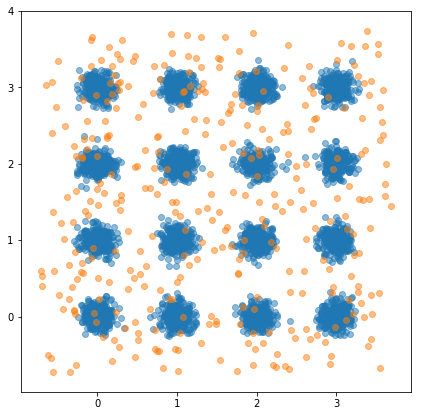

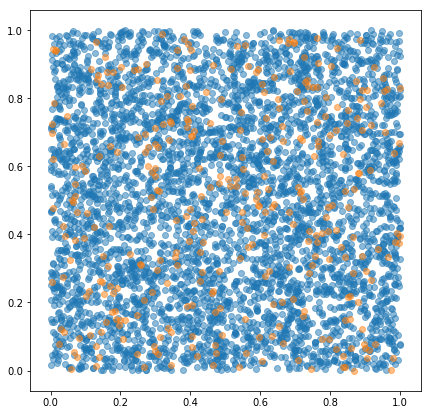

In [6]:
# visualization for first 2 features

plt.figure(figsize=(7,7))
plt.scatter(X[y==0][:,0], X[y==0][:,1], alpha=.5)
plt.scatter(X[y==1][:,0], X[y==1][:,1], alpha=.5) 
plt.show()


plt.figure(figsize=(7,7))
plt.scatter(X[y==0][:,5], X[y==0][:,-1], alpha=.5)
plt.scatter(X[y==1][:,5], X[y==1][:,-1], alpha=.5) 
plt.show()




In [7]:
clf =  IsolationForest(n_estimators=15000, max_samples=1000,contamination=float(0.07), max_features=0.1, bootstrap=False, n_jobs=-1, random_state=None, verbose=0,behaviour="new")
clf.fit(X_train)

#Isolation Forest를 사용한 이유 

# Robust Covariance를 사용하지 않은 이유 - 처음에는 scatter함수를 이용하여 feature들을 서로 비교해보면서 데이터가 어떻게 흩뿌려져 있는지 유추했다.
#그러나, 차원이 많아 이를 유추하기 굉장히 어려웠다.

# One-class SVM - Train 데이터는 Dimension이 많아서 사용하기 어려웠다.

# Local Outlier Factor - 첫번째와 두번째 feature를 비교한 것을 보자마자 LOF를 사용하는 것이 어떨까 생각하였다.
#그러나 다른 Feature들을 몇 개 비교해 보니, Dimensino이 많아서 기준이 될 Point와 그 거리를 설정하기 어려웠다.
#따라서 Isolation Forest를 사용했다.

#Isolation Forest는 Dimensionn이 높아도 잘 작동한다. 뿐만 아니라, IF의 max_feature를 보면 알 수 있듯이
#10개의 Feature중 실제로 유의미한 Feature는 1개여서 더욱 적합하였다. 또한 Train 데이터의 Lable도 가지고 있었다.
#따라서 Isolation Forest를 사용하였다.




#n_estimator=15000, max_sample=1000을 사용한 이유
#n_estimator는 tree를 만드는 횟수, max_samples는 하나의 tree를 만들 때 전체 Sample 중 몇 개를 사용하는지 이다.
#우리는 train데이터로 모델을 세운 후 train데이터로 성능을 시험하는 것이므로
#n_estimator와 max_samples는 숫자가 클 수록 AUROC값이 정확하게 나올 것이다. 
#그러나, n_estimator와 max_samples의 숫자가 크면 모델을 세울 때 Runtime이 오래 걸릴 것이다.

#n_estimator와 max_samples가 높아지면 AUROC가 약 0.981~0.985 사이의 값이 나왔다.
#따라서 우리는 AUROC의 값이 어느정도 유지되는 선에서 n_estimator와 max_samples를 낮추다 보니 위와 같은 값을 사용하게 되었다.


#contamination을 0.07로 설정한 이유
#contamination값은 전체 input sample 중에서 anormal인 비율을 말한다. 
#우리가 받은 train 데이터에서 11번째 행, 즉 label의 값들을 토대로 anormal한 값들의 비율을 구해보니 약 7%가 나왔다. 
#따라서 우리는 contamination 값을 0.07로 선정하게 되었다. 


#max_features = 0.1로 선택한 이유
#max_festures값은 전체의 feature 중 사용할 feature(column)의 비율, 즉 Random으로 뽑을 feature의 수를 정해준다.
#max_feature가 1이면 모든 feature들을 다 고려하여 tree를 만들게 된다. 
#만약, 100개의 feature중 20개의 feature만 유의미하게 outlier들을 걸러내는 중요한 feature라고 했을 때,
#max_feature = 0.2이라고 하면 tree들을 여러개 만들다가 정말 필요한 20개의 feature만 골라서 좋은 tree가 만들어질 것이다.
#우리는 처음에 max_feature = 0.1로 두었을 때 AUROC값이 가장 좋았다. 
#따라서 우리는 10개의 feature 중 1개의 feature 유의미한 feature라고 판단하여 해당 값을 0.1로 설정하였다.


IsolationForest(behaviour='new', bootstrap=False, contamination=0.07,
        max_features=0.1, max_samples=1000, n_estimators=15000, n_jobs=-1,
        random_state=None, verbose=0)

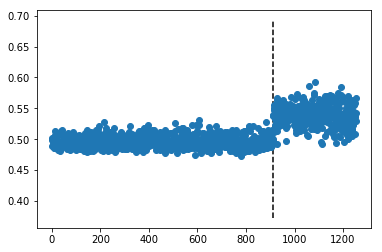

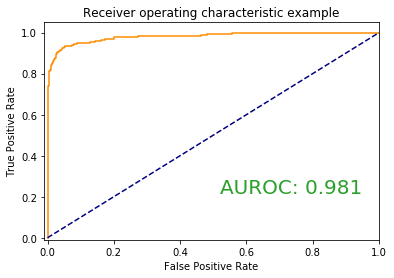

In [8]:
scores = -clf.score_samples(X_val)

plt.plot(scores, 'o')
plt.vlines(x=n_val_normal+1, ymin=min(scores)-0.1, 
           ymax=max(scores)+0.1, linestyles='--')
plt.show()

auroc = roc_auc_score(y_val, scores)
x, y, _ = roc_curve(y_val, scores)
plt.plot(x,y, color="darkorange" )
plt.title("Receiver operating characteristic example")
plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
plt.text(0.95, 0.2, "AUROC: " +str(round(auroc, 3)), {"color": "C2", "fontsize": 20},
va="bottom", ha="right")

plt.xlim([- 0.01, 1.0])
plt.ylim([- 0.01, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

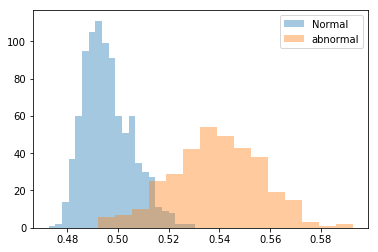

In [9]:
sns.distplot(scores[:n_val_normal], kde=False, label="Normal")
sns.distplot(scores[n_val_normal:], kde=False, label="abnormal")
plt.legend()

In [10]:
## 답안제출 (팀명을 영문이름으로 제출)
team_name = 'this_is_me' 

scores = -clf.score_samples(X_test)
np.savetxt(f'./{team_name}_test_score.csv', scores, delimiter=',')